In [1]:
import sys
sys.path.append("..")

import math
import pandas as pd
import numpy as np


from data_transformation.db_env import DbEnv, db
from data_preprocessing.data_tidying import DataTidying
from data_preprocessing.data_preprocess import DataPreprocess
from data_modeling.time_series_clustering import TimeSeriesClustering

# 1. Data Preprocessing

In [2]:
# 노래 번호 리스트 출력

conn, cursor = DbEnv().connect_sql()
list_music_num = DataTidying().get_list_music_num(cursor=cursor)

In [ ]:
# 필요할 경우 str_date, end_date 조정
df_price = DataTidying().get_df_price(list_music_num, cursor, str_date='2017-01-01', end_date='2023-12-31')
df_mcpi = DataTidying().get_df_mcpi(cursor)

In [3]:
# 가장 최근에 저장된 값 불러올 경우 피클 이용

df_price = pd.read_pickle('../storage/df_price.pkl')
df_mcpi = pd.read_pickle('../storage/df_mcpi.pkl')

In [4]:
df_price_droped, df_mcpi_droped, list_price_droped = DataPreprocess().make_df_nan_same(df_price, df_mcpi, 'date')
array_price_droped, array_mcpi_droped = df_price_droped.to_numpy(), df_mcpi_droped.to_numpy()

In [5]:
df_price_scaled = DataPreprocess().scale_df(df=df_price_droped)
df_mcpi_scaled = DataPreprocess().scale_df(df=df_mcpi_droped)

array_price_scaled = DataPreprocess().scale_array(array=array_price_droped)
array_mcpi_scaled = DataPreprocess().scale_array(array=array_mcpi_droped)

# 2. Clustering

In [6]:
array_price_scaled_t = np.transpose(array_price_scaled)

In [6]:
from minisom import MiniSom


som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(array_price_scaled_t))))

som = MiniSom(som_x, som_y,len(array_price_scaled_t[0]), sigma=0.3, learning_rate=0.1)

som.random_weights_init(array_price_scaled_t)
som.train(array_price_scaled_t, 50000)

100%|███████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.53it/s]


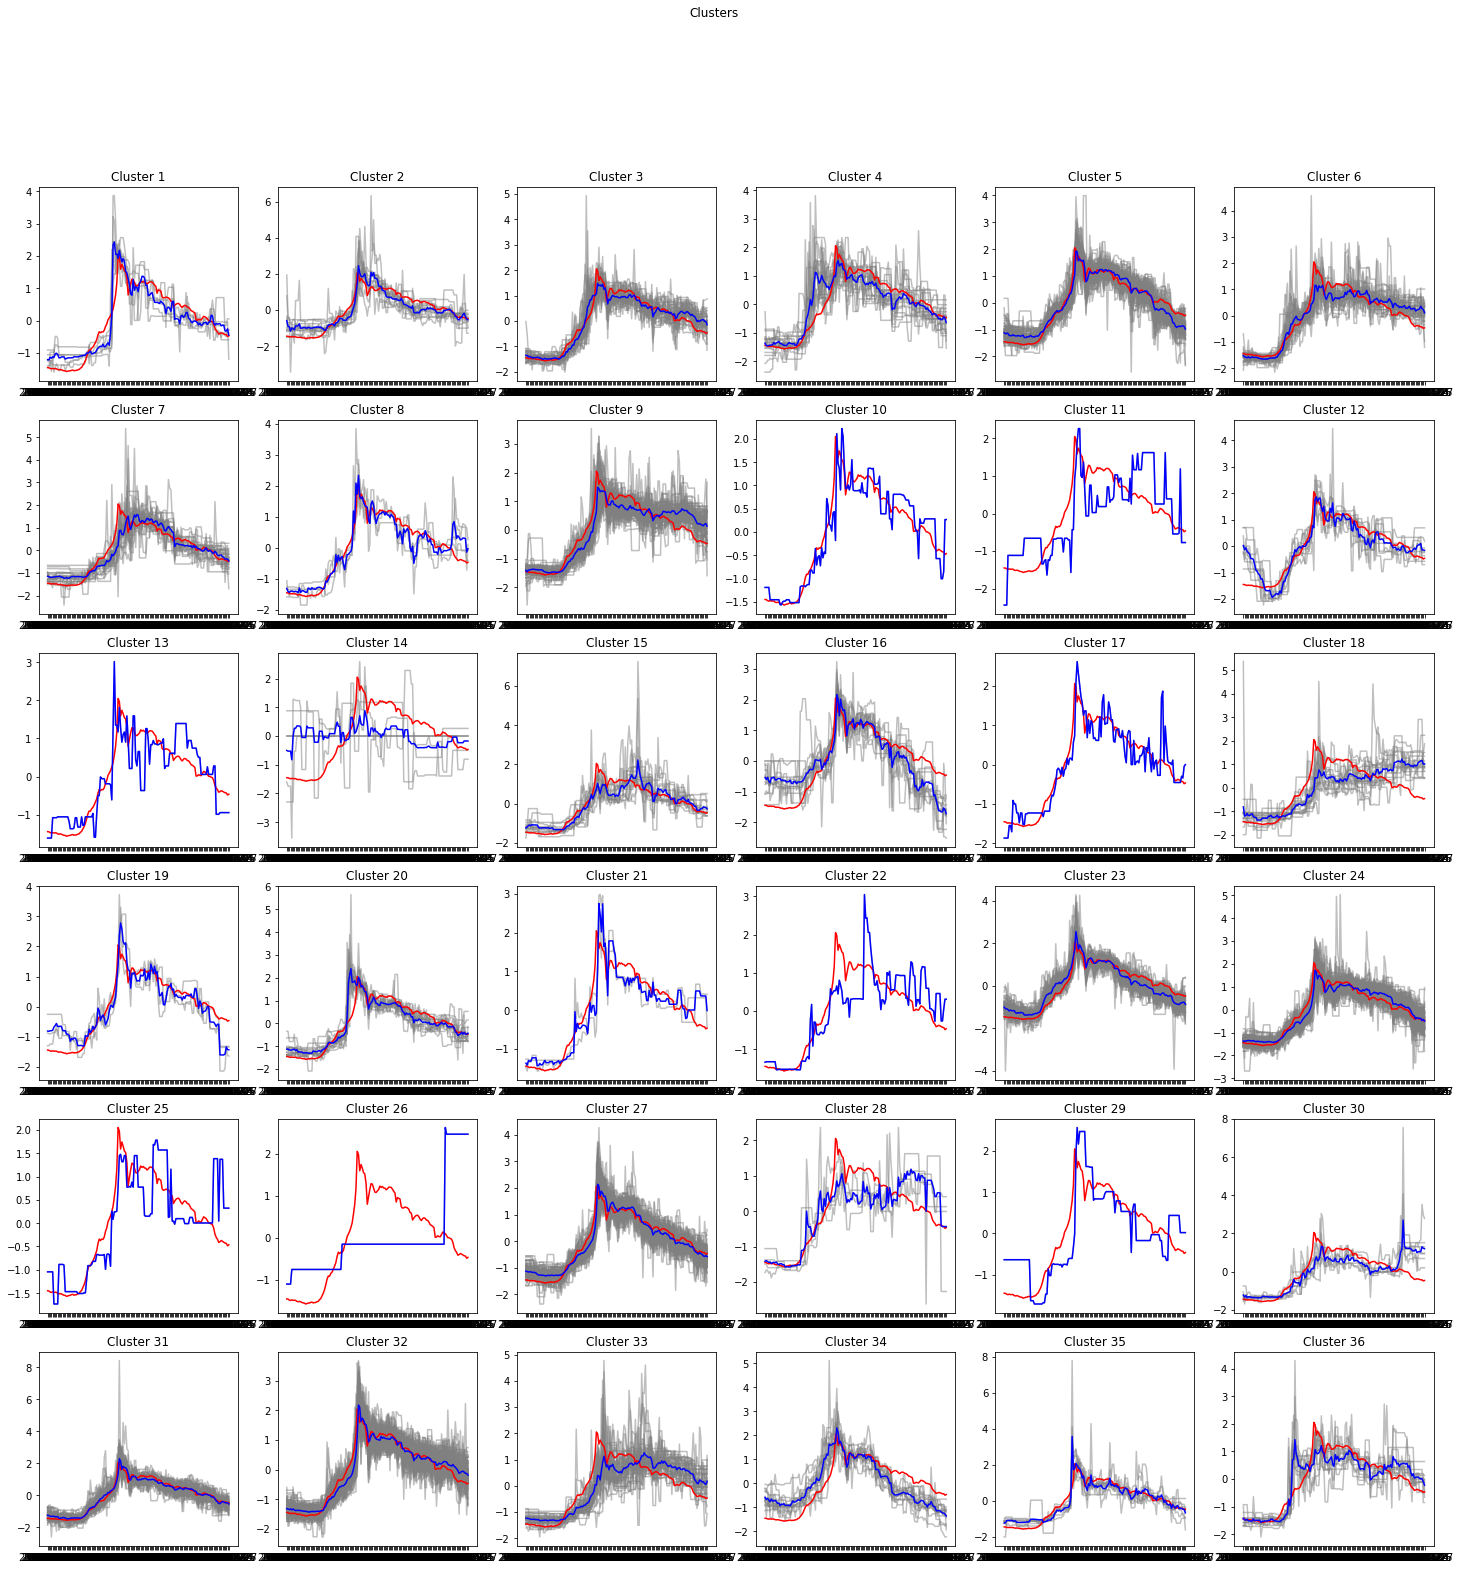

In [7]:
win_map = som.win_map(array_price_scaled_t)

TimeSeriesClustering().plot_som_series_averaged_center(som_x, som_y, win_map, df_trend=df_mcpi_scaled)

100%|███████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]


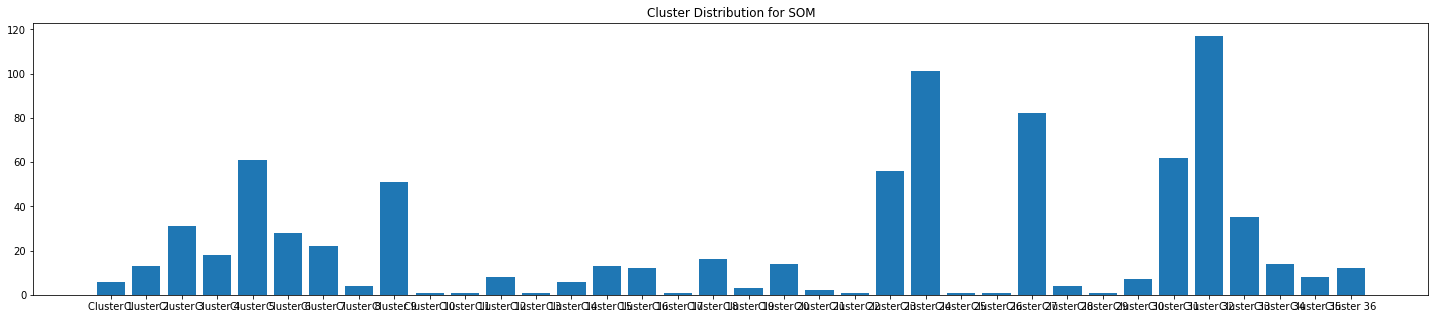

In [8]:
df_cluster_dis = TimeSeriesClustering().plot_som_cluster_distribution(som_x, som_y, win_map)

In [16]:
df_cluster_dis['clu_rate'] = df_cluster_dis['clu_name']/df_cluster_dis['clu_name'].sum()
df_cluster_dis.sort_values('clu_rate', ascending=False).head(10)

,clu_num,clu_name,clu_rate
31,Cluster 32,117,0.143735
23,Cluster 24,101,0.124079
26,Cluster 27,82,0.100737
30,Cluster 31,62,0.076167
4,Cluster 5,61,0.074939
22,Cluster 23,56,0.068796
8,Cluster 9,51,0.062654
32,Cluster 33,35,0.042998
2,Cluster 3,31,0.038084
5,Cluster 6,28,0.034398


# 3. time-series denoising

In [7]:
# denoising 진행할 행렬끼리 배치

array_price_none = df_price_droped.to_numpy()

array_price_expsmooth03 = DataPreprocess().smooth_time_series(df_time=df_price_scaled)
array_price_expsmooth06 = DataPreprocess().smooth_time_series(df_time=df_price_scaled, level=0.6)
array_price_expsmooth09 = DataPreprocess().smooth_time_series(df_time=df_price_scaled, level=0.9)

array_price_holtsmooth03 = DataPreprocess().smooth_time_series(df_time=df_price_scaled, method="holt")
array_price_holtsmooth06 = DataPreprocess().smooth_time_series(df_time=df_price_scaled, method="holt", level=0.6)
array_price_holtsmooth09 = DataPreprocess().smooth_time_series(df_time=df_price_scaled, method="holt", level=0.9)

C:\Users\abocado\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\abocado\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1439: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
C:\Users\abocado\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1445: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)


In [8]:
# 랜덤하게 추출

from random import sample

rand_num_list = sample(range(len(list_music_num)), 3)

In [9]:
# 투입할 array, 컬러, legend 명 리스트화

plt_dn_list_scaled = []
plt_denoise_list = [array_price_none, array_price_expsmooth03, array_price_expsmooth06, array_price_expsmooth09, array_price_holtsmooth03, array_price_holtsmooth06, array_price_holtsmooth09]
for a in plt_denoise_list:
    plt_dn_list = DataPreprocess().scale_array(array=a, method="MinMax")
    plt_dn_list_scaled.append(np.transpose(plt_dn_list))
name_denoise_list = ['none', 'exp03', 'exp06', 'exp09', 'holt03', 'holt06', 'holt09']
color_den_list = ["black", "lightsteelblue", "cornflowerblue", "darkblue", "mistyrose", "lightcoral", "firebrick"]

No handles with labels found to put in legend.
No handles with labels found to put in legend.


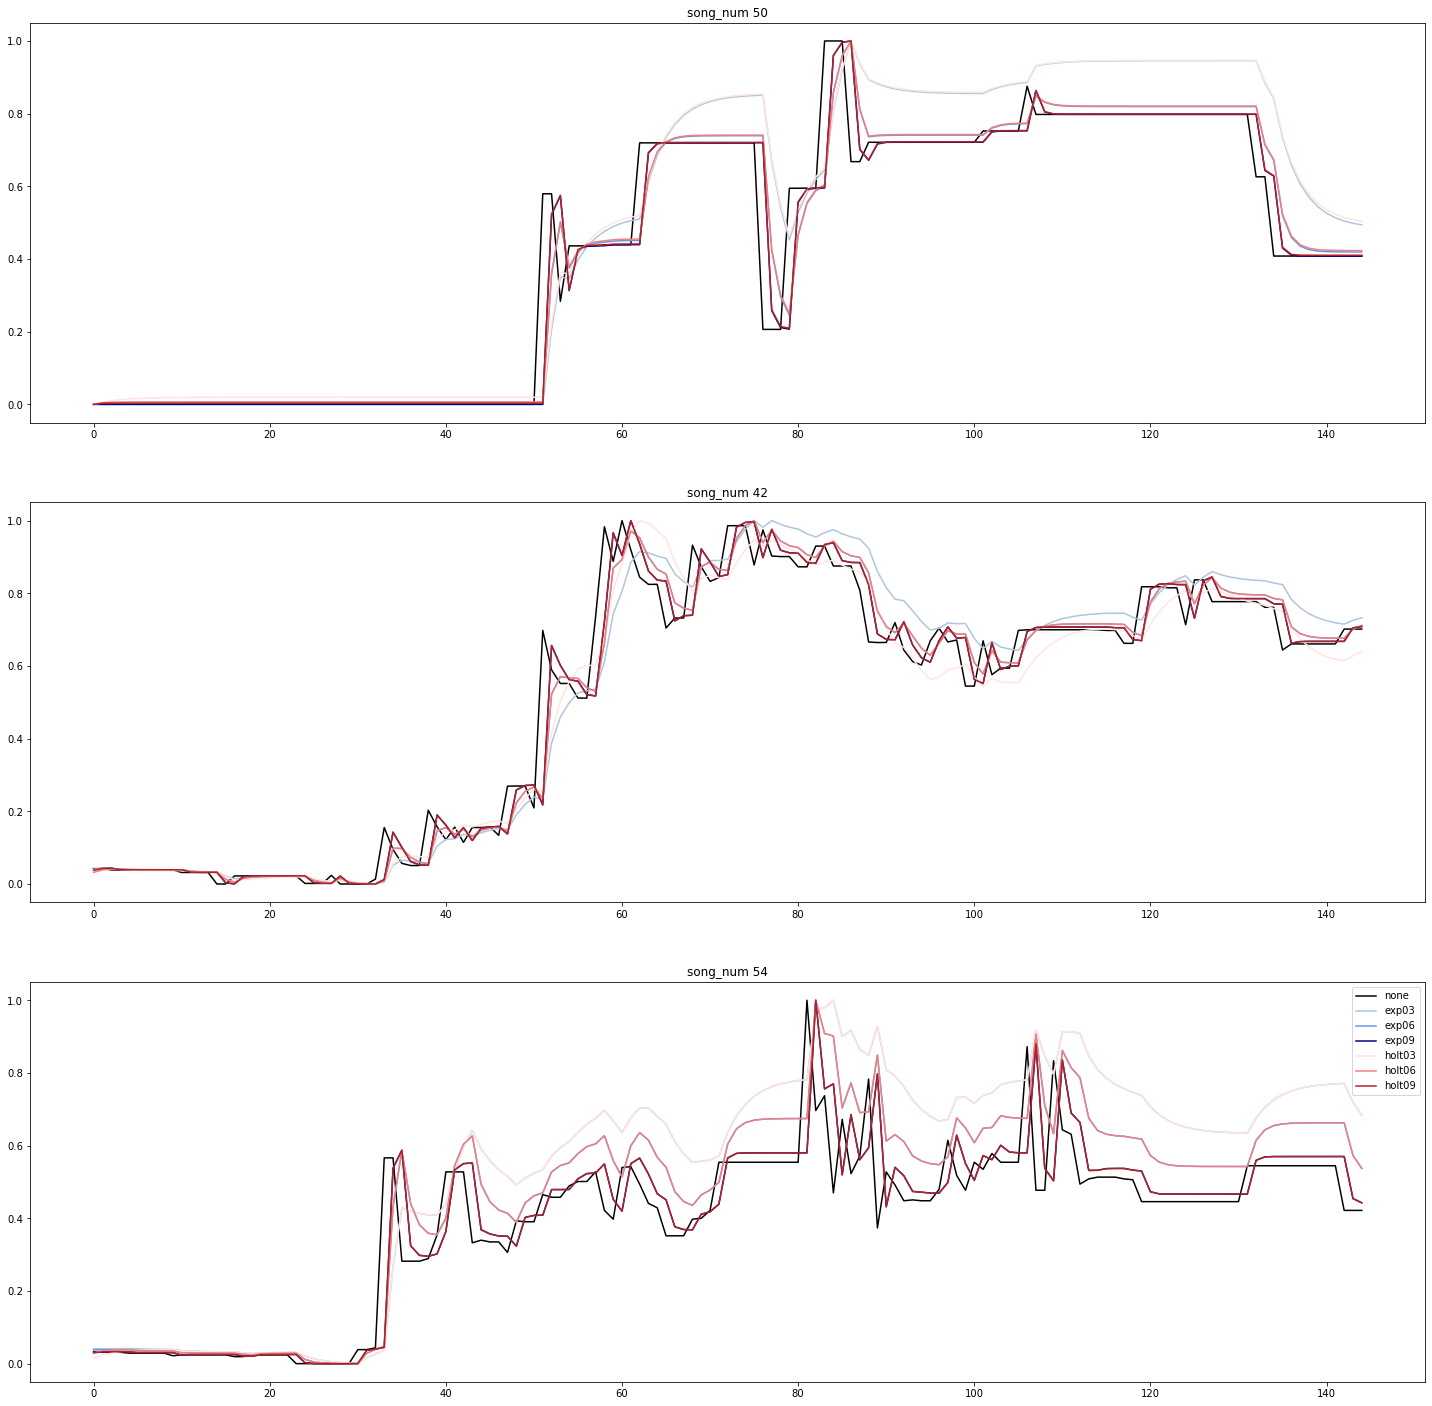

In [10]:
TimeSeriesClustering().plot_time_series_denoise(list_music_num, rand_num_list, plt_dn_list_scaled, name_denoise_list, color_den_list)